In [1]:
import os
import functools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm
import time
from IPython import display
from tensorflow import keras 
from tensorflow.keras.layers import *
from pathlib import Path
from numba import cuda 

#device = cuda.get_current_device()
#device.reset()

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# path = Path('/kaggle/input/animefacedataset/images')
path = Path("C:/Users/david/Desktop/DL Project 2/GAN/artists/artist1")
len(os.listdir(path))

877

In [4]:
img_fn = [str(path/fn) for fn in os.listdir(path)]

In [5]:
dataset = tf.data.Dataset.from_tensor_slices(img_fn)

In [6]:
def preprocess(fn):
    img = tf.io.read_file(fn)
    img = tf.image.decode_jpeg(img, 3)
    img = tf.cast(img, dtype=tf.float32)
    img = (img - 127.5) / 127.5
    img = tf.image.resize(img, (128, 128))
    return img

In [7]:
dataset = dataset.map(preprocess, num_parallel_calls=-1).cache()

In [8]:
dataset = dataset.shuffle(877).batch(32, drop_remainder=True)

In [9]:
dataset = dataset.prefetch(32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


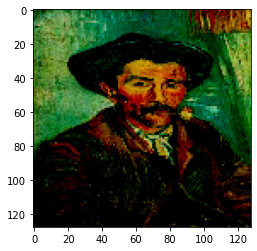

In [10]:
plt.imshow(next(dataset.as_numpy_iterator())[31])

In [11]:
next(dataset.as_numpy_iterator())[:8].shape

(8, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


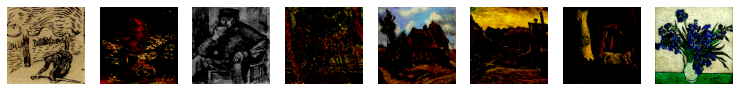

In [12]:
def show(images):
    fig, ax = plt.subplots(1, 8, figsize=(13, 13))
    for i, a in enumerate(ax):
        a.imshow(np.squeeze(images[i]))
        a.axis('off')
    plt.show()
show(next(dataset.as_numpy_iterator())[:8])

In [13]:
class WeightClipping(keras.constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
    def __call__(self, weights):
        return tf.clip_by_value(weights, -self.clip_value, self.clip_value)

In [14]:
class ConvLayer(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv = Conv2D(nf, ks, strides=strides, padding=padding,
                           kernel_initializer='he_normal', kernel_constraint=constraint, use_bias=False)
#         self.bn = BatchNormalization()
        self.norm = LayerNormalization()
        self.act = LeakyReLU(0.2)
        
    def call(self, X):
        X = self.act(self.conv(X))
        return self.norm(X)
    
def conv_layer(nf, ks, strides=2, padding='same'):
    conv = Conv2D(nf, ks, strides=strides, padding=padding, use_bias=False)
    bn = BatchNormalization()
    act = LeakyReLU(0.2)
    return keras.Sequential([conv, act, bn])

In [15]:

def critic(input_shape=(128, 128, 3), dim=128, n_downsamplings=5):
    h = inputs = keras.Input(shape=input_shape)
    # 1: downsamplings, 128x128| -> 64x64 -> 32x32 -> 16x16 -> 8x8 -> 4x4
    h = ConvLayer(dim, 4, strides=2, padding='same')(h)
    for i in range(n_downsamplings - 1):
        d = min(dim * 2 ** (i + 1), dim * 8)
        h = ConvLayer(d, 4, strides=2, padding='same')(h)

    h = keras.layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer='he_normal')(h)
    h = Flatten()(h)
    return keras.Model(inputs=inputs, outputs=h)

In [16]:
d = critic()
d.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv_layer (ConvLayer)       (None, 64, 64, 128)       6400      
_________________________________________________________________
conv_layer_1 (ConvLayer)     (None, 32, 32, 256)       524800    
_________________________________________________________________
conv_layer_2 (ConvLayer)     (None, 16, 16, 512)       2098176   
_________________________________________________________________
conv_layer_3 (ConvLayer)     (None, 8, 8, 1024)        8390656   
_________________________________________________________________
conv_layer_4 (ConvLayer)     (None, 4, 4, 1024)        16779264  
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 1)           16385 

In [17]:
class UpsampleBlock(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding, 
                                              kernel_initializer='he_normal', kernel_constraint=constraint)
#         self.bn = BatchNormalization()
        self.norm = LayerNormalization()
        self.act = ReLU()
        
    def call(self, X):
        X = self.act(self.conv_transpose(X))
        return self.norm(X)
    
def deconv_layer( nf, ks, strides=2, padding='same'):
    conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding)
    bn = BatchNormalization()
    act = ReLU()
    return keras.Sequential([conv_transpose, act, bn])

In [18]:
def generator(input_shape=(1, 1, 128), output_channels=3, dim=128, n_upsamplings=5):
    h = inputs = keras.Input(shape=input_shape)
    d = min(dim * 2 ** (n_upsamplings - 1), dim * 8)
    h = UpsampleBlock(d, 4, strides=1, padding='valid')(h)
    
    #  upsamplings, 4x4| -> 8x8 -> 16x16 -> 32x32 -> 64x64-> 128x128
    for i in range(n_upsamplings - 1):
        d = min(dim * 2 ** (n_upsamplings - 2 - i), dim * 8)
        h = UpsampleBlock(d, 4, strides=2, padding='same')(h)
        
    h = keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                     kernel_initializer='he_normal')(h)
    h = keras.layers.Activation('tanh')(h)

    return keras.Model(inputs=inputs, outputs=h)

In [19]:
g = generator()
g.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 128)]       0         
_________________________________________________________________
upsample_block (UpsampleBloc (None, 4, 4, 1024)        2100224   
_________________________________________________________________
upsample_block_1 (UpsampleBl (None, 8, 8, 1024)        16780288  
_________________________________________________________________
upsample_block_2 (UpsampleBl (None, 16, 16, 512)       8390144   
_________________________________________________________________
upsample_block_3 (UpsampleBl (None, 32, 32, 256)       2097920   
_________________________________________________________________
upsample_block_4 (UpsampleBl (None, 64, 64, 128)       524672    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 128, 128, 3)       6147

In [20]:
#Wasserstein loss
def d_loss(real, fake):
    real_loss = -tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
#     real_lbl = tf.ones_like(real)
#     fake_lbl = tf.zeros_like(fake)
#     real_loss = tf.losses.binary_crossentropy(real_lbl, real)
#     fake_loss = tf.losses.binary_crossentropy(fake_lbl, fake)
    return real_loss + fake_loss

def g_loss(fake):
#     return tf.losses.binary_crossentropy(tf.ones_like(fake), fake)
    return - tf.reduce_mean(fake)

In [21]:
@tf.function
def gradient_penalty(model, real, fake):
    shape = [tf.shape(real)[0]] + [1, 1, 1]
    alpha = tf.random.uniform(shape=shape, minval=0, maxval=1)
    interpolated = alpha * real  + (1-alpha) * fake
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = model(interpolated)
    grad = tape.gradient(pred, interpolated)
    norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [22]:
EPOCHS = 100
BATCH_SIZE = 32
noise_dim = 128

In [23]:
optD = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)
optG = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)

In [24]:
@tf.function
def trainD(real):
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        fake_images = g(noise, training=True)
        real_output = d(real, training=True)
        fake_output = d(fake_images, training=True)
        gp_loss = gradient_penalty(functools.partial(d, training=True), real, fake_images)
        loss = d_loss(real_output, fake_output)
        disc_loss = loss + 10 * gp_loss
        
    d_grad = tape.gradient(disc_loss, d.trainable_variables)
    optD.apply_gradients(zip(d_grad, d.trainable_variables))
    
    
@tf.function
def trainG():
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        generated_images = g(noise, training=True)
        loss = g_loss(d(generated_images))
        
    g_grad = tape.gradient(loss, g.trainable_variables)
    optG.apply_gradients(zip(g_grad, g.trainable_variables))

In [25]:
seed = tf.random.normal((16, 1, 1, 128))


In [33]:
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig, ax = plt.subplots(4, 4, figsize=(10,10))

    for i, a in enumerate(ax.flat):
        a.imshow(predictions[i, :, :, :])
        a.axis('off')
    plt.savefig("C:/Users/david/Desktop/DL Project 2/GAN/WGAN FINAL/Generated WGAN FINAL5/train_image" + str(epoch) + ".png")
    plt.show()
    



In [27]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in tqdm.tqdm(dataset, total=877//BATCH_SIZE):
          # train_step(image_batch)
            trainD(image_batch)
            if optD.iterations.numpy() % 5 == 0:
                trainG()

        display.clear_output(wait=True)
        generate_images(g, epoch + 1, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [ ]:
#g.load_weights("WGAN_VANG_400r_G.hdf5")
#d.load_weights("WGAN_VANG_400r_D.hdf5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

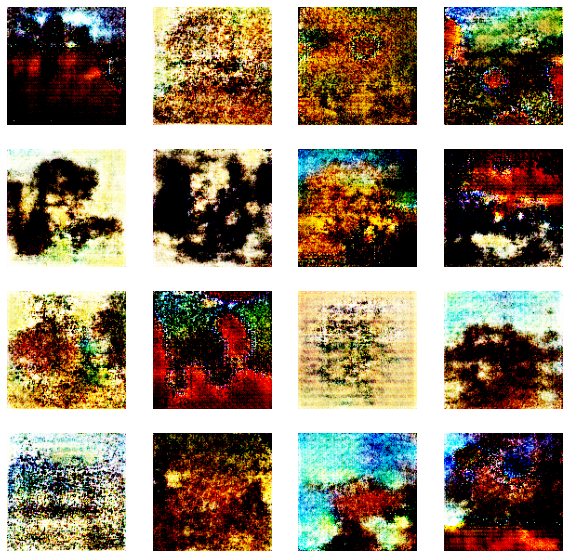

Time for epoch 100 is 23.81700348854065 sec


In [30]:
train(dataset, EPOCHS)

In [31]:
g.save_weights("WGAN_VANG_500r_G.hdf5")

In [32]:
d.save_weights("WGAN_VANG_500r_D.hdf5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

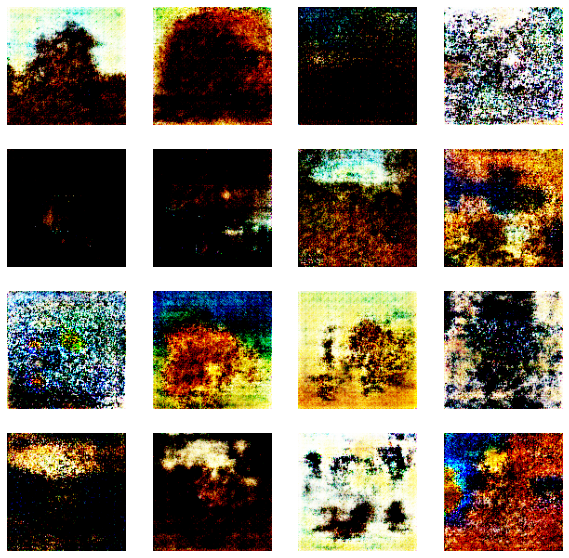

In [35]:
generate_images(g, 501, tf.random.normal([16, 1, 1, 128]))
